In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [20, 30, 40], 
    'max_depth': [-1, 10, 20, 30],
    'reg_alpha': [0, 1, 2, 3], 
    'reg_lambda': [0, 1, 1.5],  
    'learning_rate': [0.01, 0.05, 0.1],
    'bagging_fraction': [0.9, 1],
}

gbm = LGBMClassifier(
    objective='binary',
    metric='auc',
    verbose=-1
)

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
 
grid = GridSearchCV(
    estimator=gbm, 
    param_grid=param_grid, 
    scoring='roc_auc',
    cv=rskf,
    verbose=1,
    n_jobs=-1
)

with tqdm(total=len(param_grid)) as pbar:
    grid.fit(X, y)
    pbar.update(1)
print(f'Best parameters found by grid search are: {grid.best_params_}')

In [3]:
!pip install lightgbm --quiet
!pip install prettytable --quiet

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from lightgbm import LGBMClassifier
from tqdm import tqdm 

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve, precision_recall_curve, matthews_corrcoef, precision_score
from sklearn.metrics import auc as sklearn_auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight


In [7]:
df = pd.read_csv('../data/model_data.csv')

In [8]:
df.shape

(8370, 16)

In [9]:
backup = df.copy()

## Data preprocessing

In [79]:
df = df.drop_duplicates()

In [80]:
df.comparacao_ufs_rntrcs.value_counts()

comparacao_ufs_rntrcs
True     8162
False      94
Name: count, dtype: int64

In [81]:
df[df['comparacao_ufs_rntrcs'].isna() == True]

,sinistro,mot_prop_alguma_placa,mot_prop_todas_placas,mot_prop_algum_rntrc,mot_prop_todos_rntrc,msm_proprietario_todas_placas,msm_proprietario_todos_documentos,msm_prop_alguma_placa_algum_documento,msm_prop_algum_placa_todos_documentos,msm_prop_todas_placas_algum_doc,msm_prop_all,comparacao_ufs_rntrcs,days_difference_lower,days_difference_higher,total_plates,percentual_cpfs


## Model pipeline and evaluation

In [82]:
dummy_columns = [col for col in df.columns if df[col].dtype == 'bool']
num_columns = ['days_difference_lower', 'days_difference_higher', 'total_plates', 'percentual_cpfs']
X = df[dummy_columns + num_columns] 
y = df['sinistro']

In [84]:
len(X.columns)

15

In [13]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'bagging_fraction': 0.9, 
    'metric':'auc', 
    'learning_rate': 0.05,
    'max_depth': -1,
    'n_estimators': 200,
    'num_leaves': 20,
    'reg_alpha': 0, 
    'reg_lambda': 0,
    'verbose': -1
}

In [14]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [15]:
X.shape

(8256, 15)

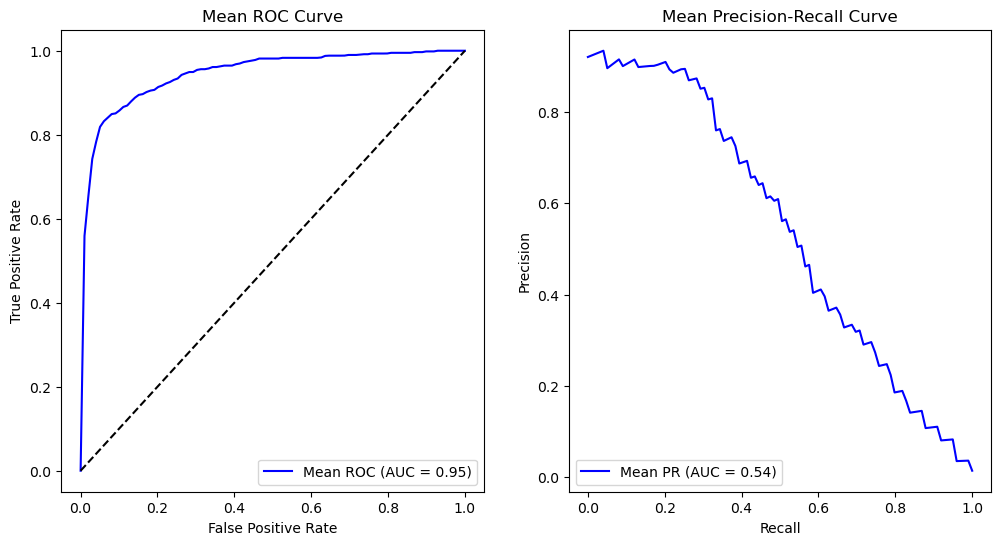

In [16]:
df_reports = []
auc_scores = []
auc_pr_scores = []
mcc_scores = []
tprs = []  
aucs_roc = [] 
precisions_list = []
recalls_list = [] 
aucs_pr = []
mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)
all_y_pred = []
all_y_pred_proba = []
trained_models = []
all_X_train = []
all_X_test = []
all_y_train = []
all_y_test = []
all_y_test_list = []
all_y_pred_list = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    all_X_train.append(X_train)
    all_X_test.append(X_test)
    all_y_train.extend(y_train)
    all_y_test.extend(y_test)
    all_y_test_list.append(y_test)

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    gbm = LGBMClassifier(**params)
    gbm.fit(X_train, y_train, sample_weight=sample_weights)
    
    trained_models.append(gbm)

    y_pred = gbm.predict(X_test)
    y_pred_proba = gbm.predict_proba(X_test)[:, 1]
    
    all_y_pred.extend(gbm.predict(X_test))
    all_y_pred_list.append(gbm.predict(X_test))
    all_y_pred_proba.extend(y_pred_proba)

    report = classification_report(y_test, y_pred, output_dict=True)
    
    flat_report = {}
    for key, value in report.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                flat_report[f"{key}_{sub_key}"] = sub_value
        else:
            flat_report[key] = value
    
    df_reports.append(flat_report)

    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc_score)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_pr = sklearn_auc(recall, precision)
    auc_pr_scores.append(auc_pr)

    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs_roc.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    precisions_list.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
    pr_auc = auc(recall, precision)
    aucs_pr.append(pr_auc)

avg_report_df = pd.DataFrame(df_reports).mean()
avg_report_df['AUC'] = np.mean(auc_scores)
avg_report_df['AUC-PR'] = np.mean(auc_pr_scores)
avg_report_df['MCC'] = np.mean(mcc_scores)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc_roc = auc(mean_fpr, mean_tpr)

mean_precision = np.mean(precisions_list, axis=0)
mean_auc_pr = auc(mean_recall, mean_precision)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f)' % mean_auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(mean_recall, mean_precision, color='blue', label=r'Mean PR (AUC = %0.2f)' % mean_auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()

In [17]:
report_df = pd.DataFrame(avg_report_df)
report_df = report_df.reset_index()
report_df[['Metric', 'Measure']] = report_df['index'].str.rsplit('_', n=1, expand=True)
report_df.drop(columns='index', inplace=True)
report_df = report_df.pivot(index='Metric', columns='Measure', values=0)
report_df.columns = ['drop', 'f1-score', 'precision', 'recall', 'support']
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]

for metric in ['accuracy', 'AUC', 'AUC-PR', 'MCC']:
    report_df.loc[metric] = [avg_report_df.get(metric)] * 4

x = PrettyTable()

x.field_names = [''] + list(report_df.columns)

for index, row in report_df.iterrows():
    x.add_row([index] + list(round(row, 2)))

print(x)


+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |    0.99   |  0.98  |   0.99   |  1627.6 |
|      1       |    0.36   |  0.61  |   0.45   |   23.6  |
|     AUC      |    0.95   |  0.95  |   0.95   |   0.95  |
|    AUC-PR    |    0.54   |  0.54  |   0.54   |   0.54  |
|     MCC      |    0.45   |  0.45  |   0.45   |   0.45  |
|   accuracy   |    0.98   |  0.98  |   0.98   |   0.98  |
|  macro avg   |    0.68   |  0.8   |   0.72   |  1651.2 |
| weighted avg |    0.99   |  0.98  |   0.98   |  1651.2 |
+--------------+-----------+--------+----------+---------+


In [18]:
def plot_confusion_matrixs(y_test, y_pred):
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(16, 6)) 

    plt.subplot(1, 2, 1)  
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)  
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

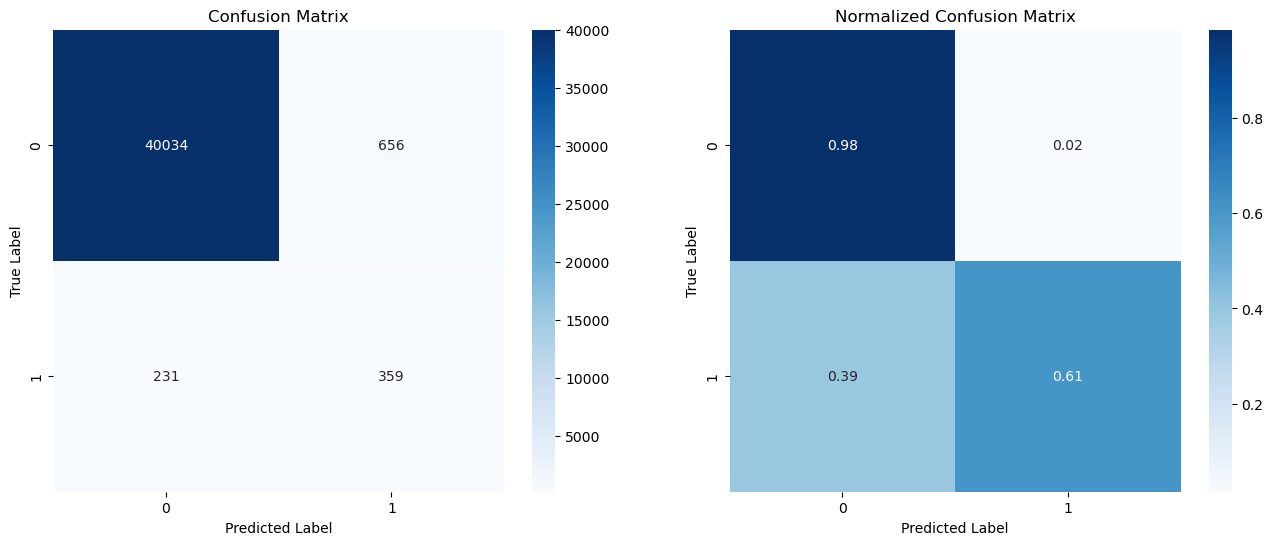

In [19]:
plot_confusion_matrixs(all_y_test, all_y_pred)

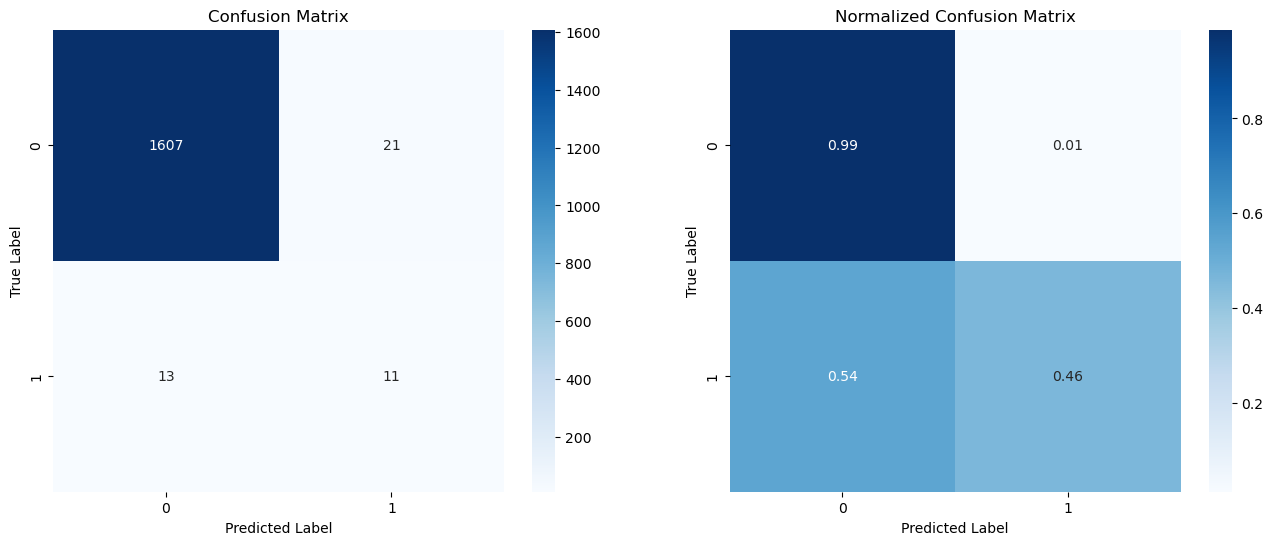

In [20]:
plot_confusion_matrixs(all_y_test_list[0], all_y_pred_list[0])

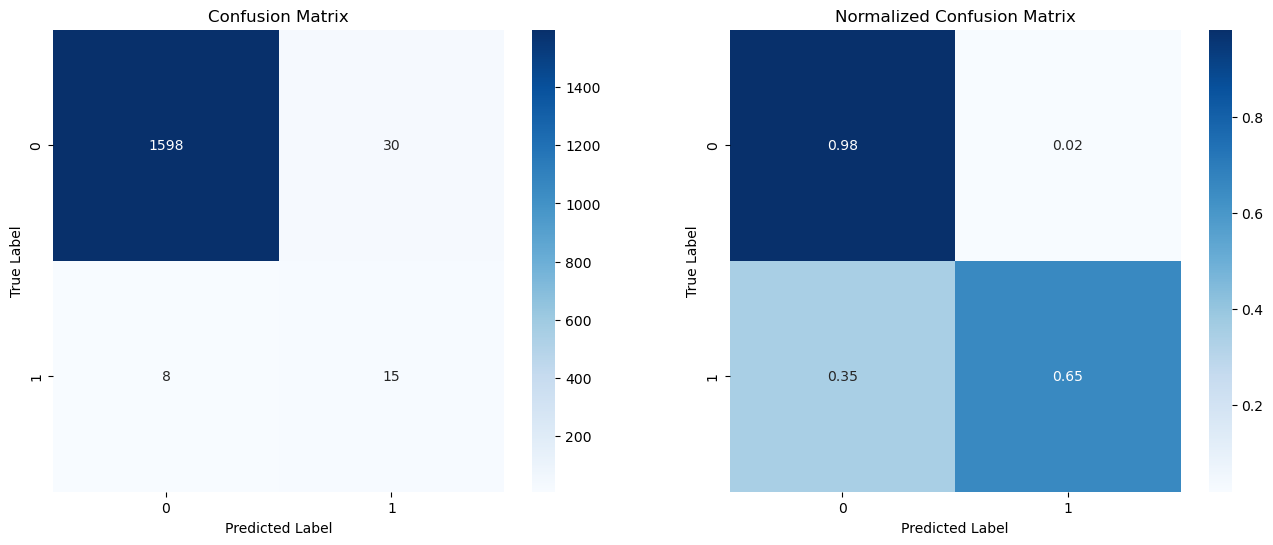

In [21]:
plot_confusion_matrixs(all_y_test_list[1], all_y_pred_list[1])

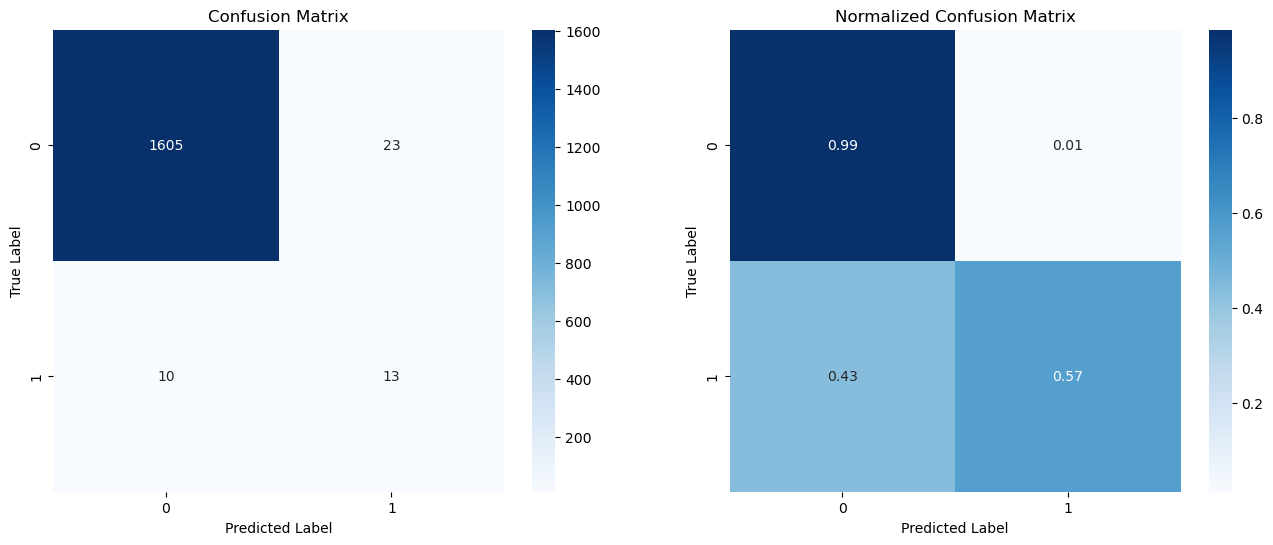

In [22]:
plot_confusion_matrixs(all_y_test_list[2], all_y_pred_list[2])

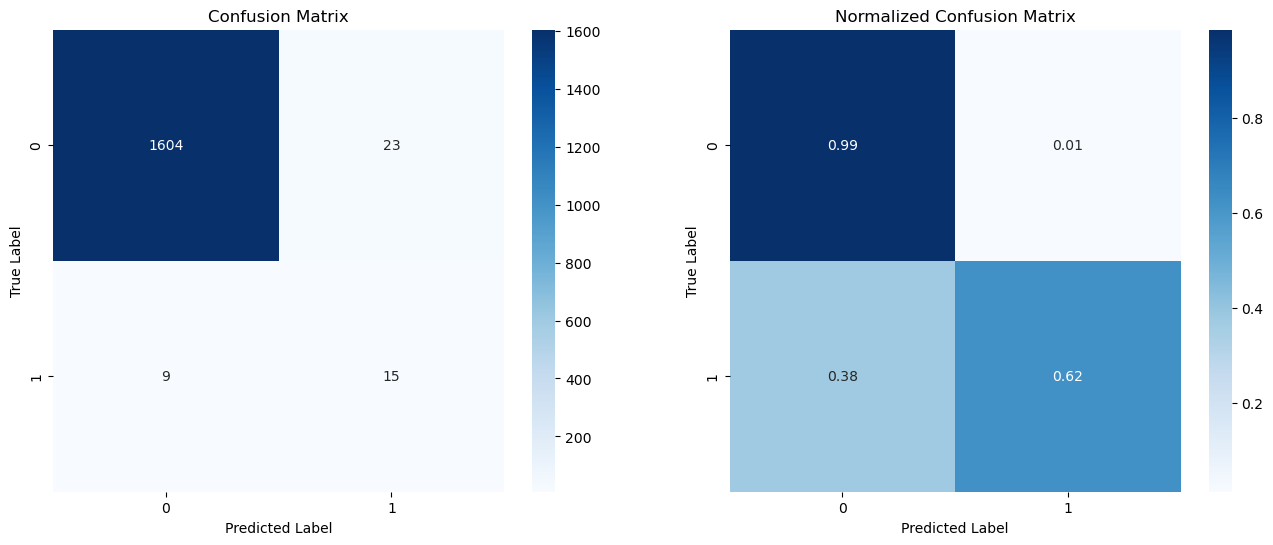

In [23]:
plot_confusion_matrixs(all_y_test_list[3], all_y_pred_list[3])

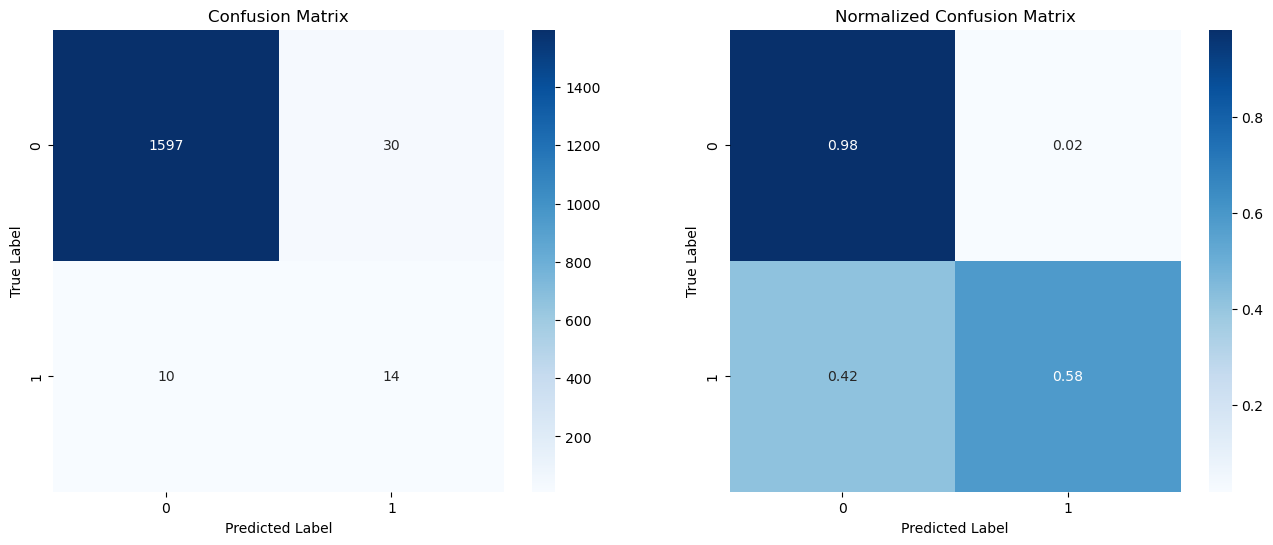

In [24]:
plot_confusion_matrixs(all_y_test_list[4], all_y_pred_list[4])

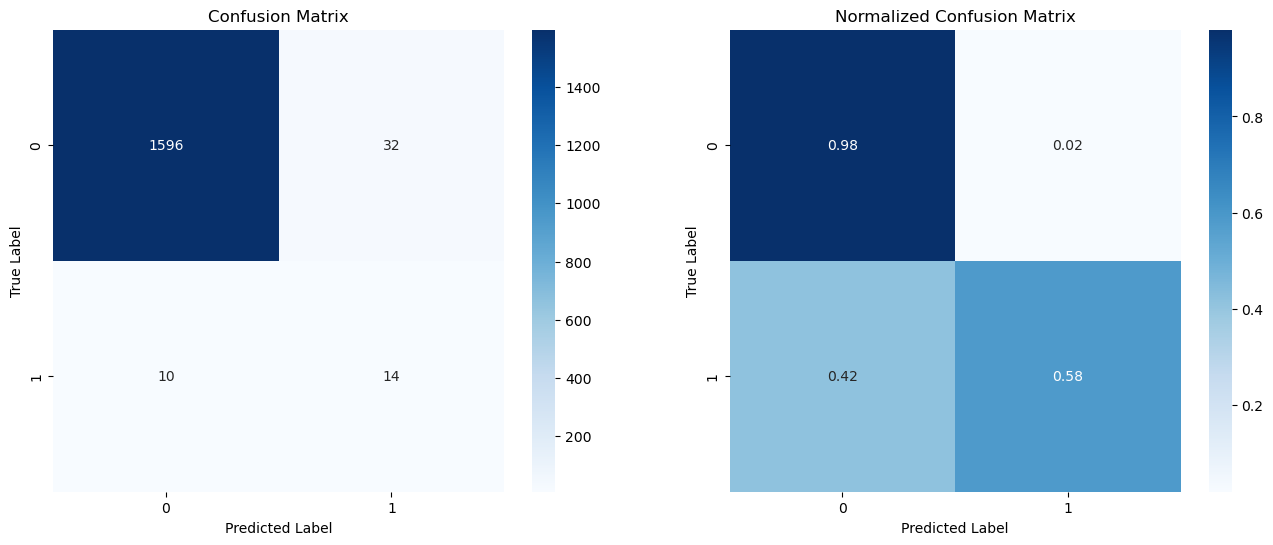

In [25]:
plot_confusion_matrixs(all_y_test_list[5], all_y_pred_list[5])

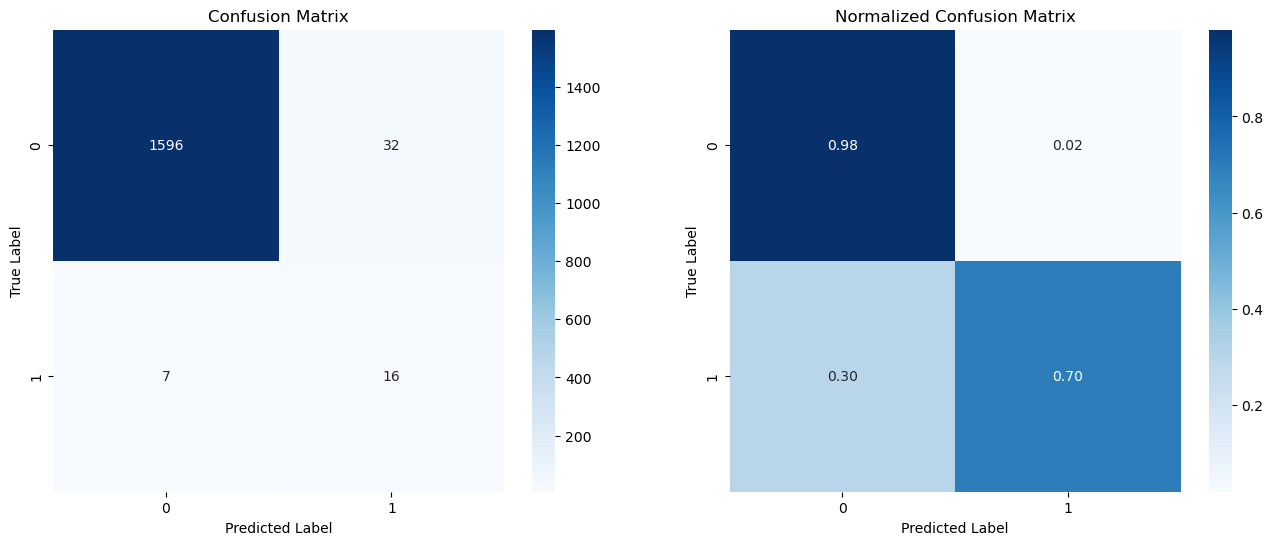

In [26]:
plot_confusion_matrixs(all_y_test_list[6], all_y_pred_list[6])

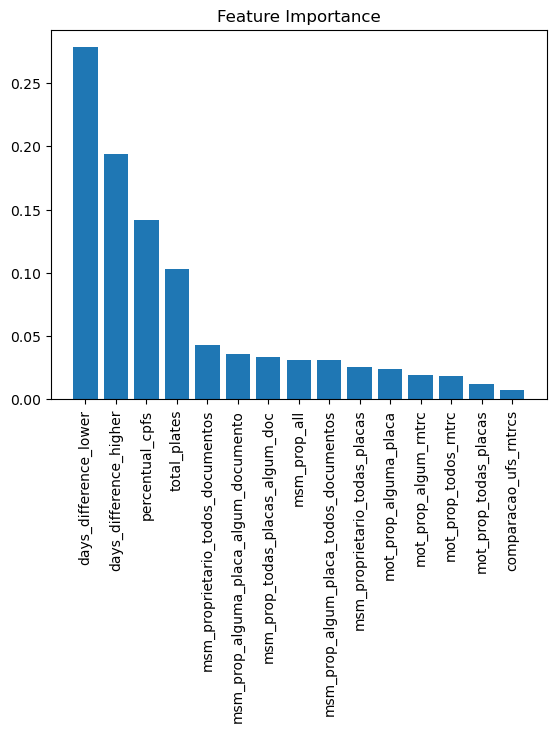

In [27]:
feature_importances = np.mean([model.feature_importances_ for model in trained_models], axis=0)

feature_importances = feature_importances / sum(feature_importances)
sorted_indices = np.argsort(feature_importances)[::-1]

plt.bar(range(X.shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.show()

In [28]:
sum(y_test)/len(y_test)

0.014536644457904301

In [29]:
sum(y_pred)/len(y_pred)

0.018170805572380374

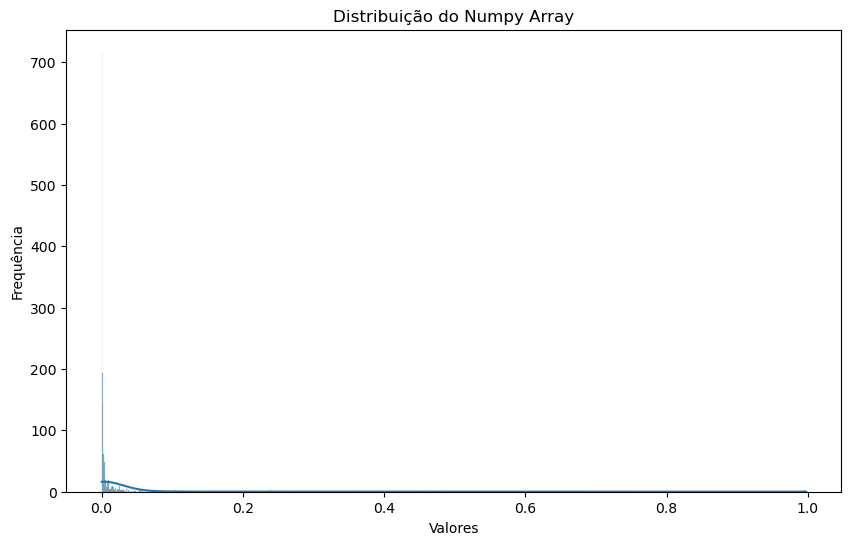

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(y_pred_proba, kde=True, ax=ax)
ax.set_title('Distribuição do Numpy Array')
ax.set_xlabel('Valores')
ax.set_ylabel('Frequência')
plt.show()

### Thresholds

In [31]:
precision, recall, thresholds = precision_recall_curve(all_y_test, all_y_pred_proba)

### f1-score threshold

In [32]:
f1_scores = []
for p, r in zip(precision, recall):
    if p == 0 and r == 0:
        f1 = 0  # Define o F1-score como zero se ambos precisão e revocação forem zero
    else:
        f1 = 2 * (p * r) / (p + r)
    f1_scores.append(f1)

In [33]:
max_f1_index = np.argmax(f1_scores)

In [34]:
best_threshold = thresholds[max_f1_index]
best_f1_score = f1_scores[max_f1_index]

In [35]:
print(f"Melhor limiar: {best_threshold}")
print(f"Melhor F1-score: {best_f1_score}")

Melhor limiar: 0.8566814023711089
Melhor F1-score: 0.5337078651685393


### recall threshold

In [36]:
max_recall_index = np.argmax(recall)

In [37]:
best_threshold = thresholds[max_recall_index]
best_recall_score = recall[max_recall_index]
recall_precision_score = precision[max_recall_index]

In [38]:
print(f"Melhor limiar: {best_threshold}")
print(f"Melhor recall: {best_recall_score}")
print(f"precision-score correspondente: {recall_precision_score}")

Melhor limiar: 4.773715672957509e-06
Melhor recall: 1.0
precision-score correspondente: 0.014292635658914728


### Precision threshold

In [39]:
max_precision_index = np.argmax(precision)

In [40]:
if max_precision_index == len(thresholds):
    max_precision_index -= 1

best_threshold = thresholds[max_precision_index]
best_precision_score = precision[max_precision_index]
recall_at_best_precision = recall[max_precision_index]

In [41]:
print(f"Melhor limiar: {best_threshold}")
print(f"Melhor precision-score: {best_precision_score}")
print(f"Recall correspondente: {recall_precision_score}")

Melhor limiar: 0.9972750519000171
Melhor precision-score: 1.0
Recall correspondente: 0.014292635658914728


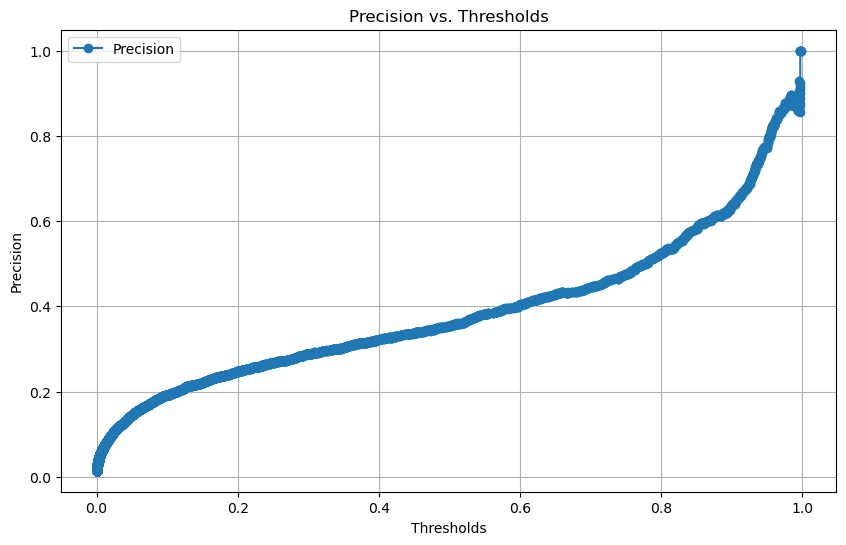

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.xlabel('Thresholds')
plt.ylabel('Precision')
plt.title('Precision vs. Thresholds')
plt.legend()
plt.grid(True)
plt.show()

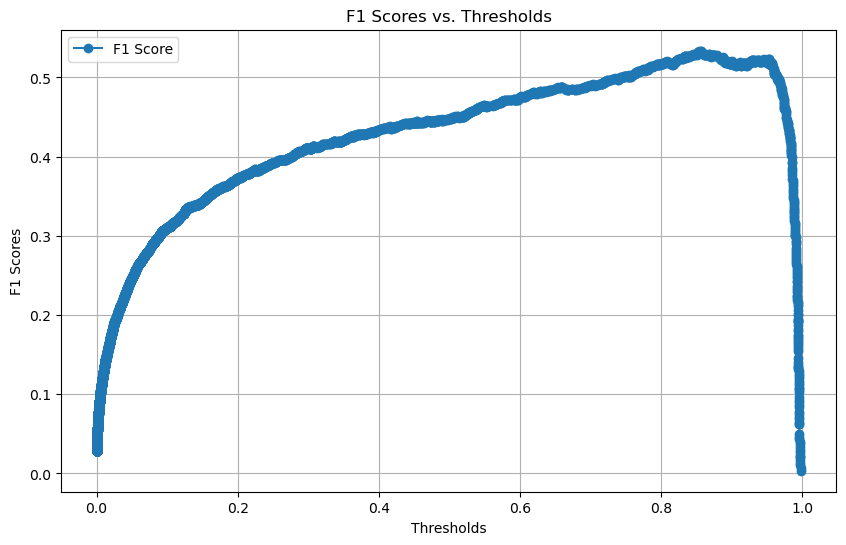

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], marker='o', label='F1 Score')
plt.xlabel('Thresholds')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs. Thresholds')
plt.legend()
plt.grid(True)
plt.show()

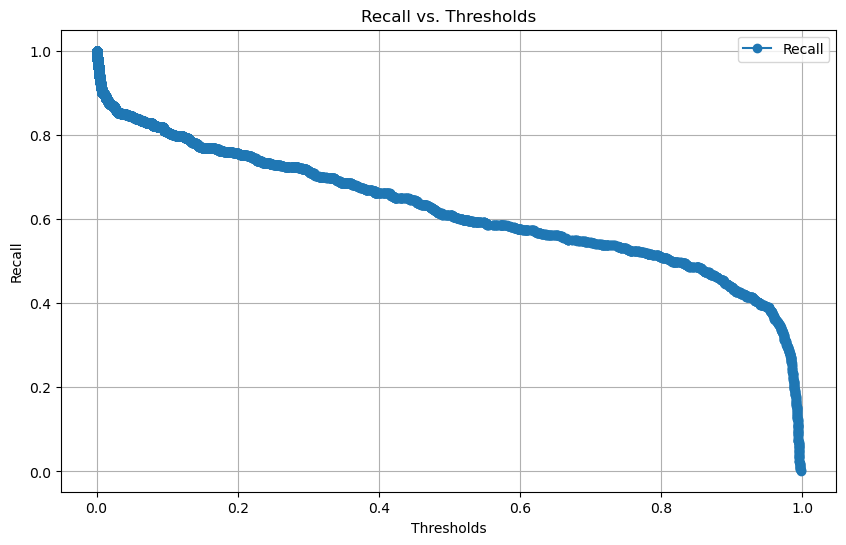

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.xlabel('Thresholds')
plt.ylabel('Recall')
plt.title('Recall vs. Thresholds')
plt.legend()
plt.grid(True)
plt.show()

### Model 0

In [45]:
chosen_model = trained_models[0]

explainer = shap.TreeExplainer(chosen_model)
shap_values_train = explainer.shap_values(all_X_train[0])

shap_values_test = explainer.shap_values(all_X_test[0])

shap.summary_plot(shap_values_train, all_X_train[0], plot_type="bar")

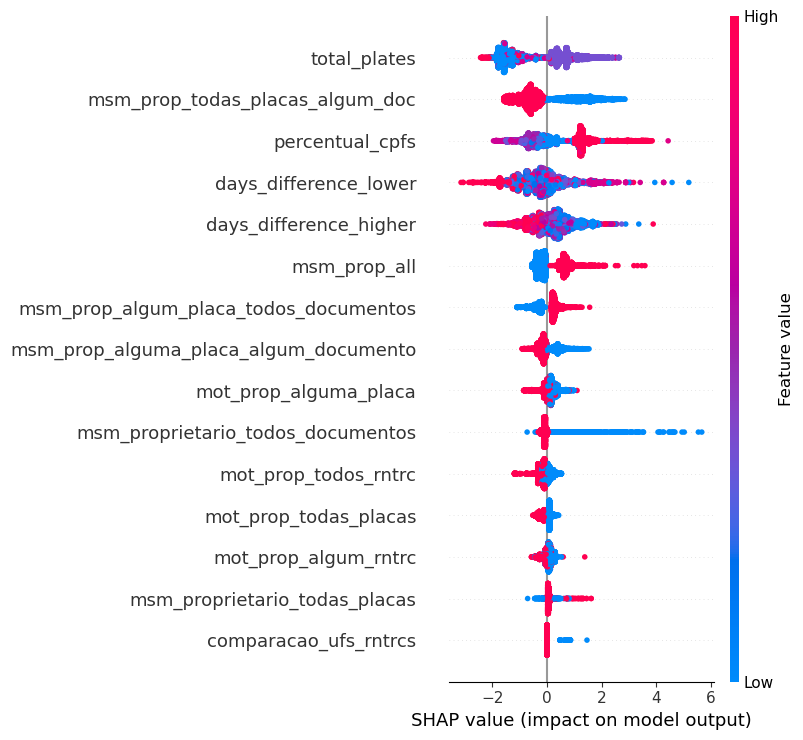

In [46]:
shap.summary_plot(shap_values_train[1], all_X_train[0], plot_type="dot")

shap.summary_plot(shap_values_test, all_X_test[0], plot_type="bar")

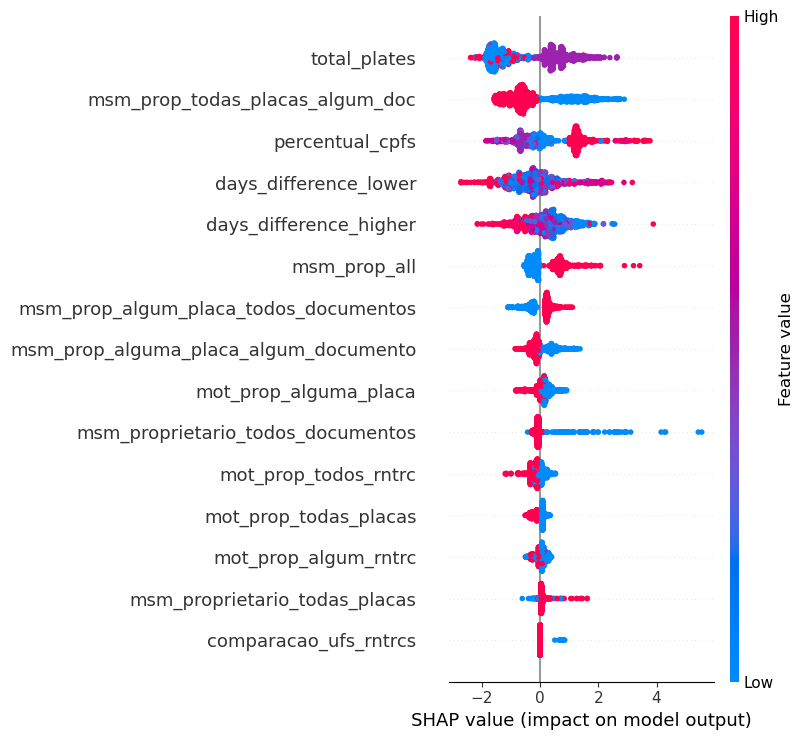

In [47]:
shap.summary_plot(shap_values_test[1], all_X_test[0], plot_type="dot")

### Model 1

In [48]:
chosen_model = trained_models[1]

explainer = shap.TreeExplainer(chosen_model)
shap_values_train = explainer.shap_values(all_X_train[1])

explainer_test = shap.TreeExplainer(chosen_model)
shap_values_test = explainer.shap_values(all_X_test[1])

shap.summary_plot(shap_values_train, all_X_train[0], plot_type="bar")

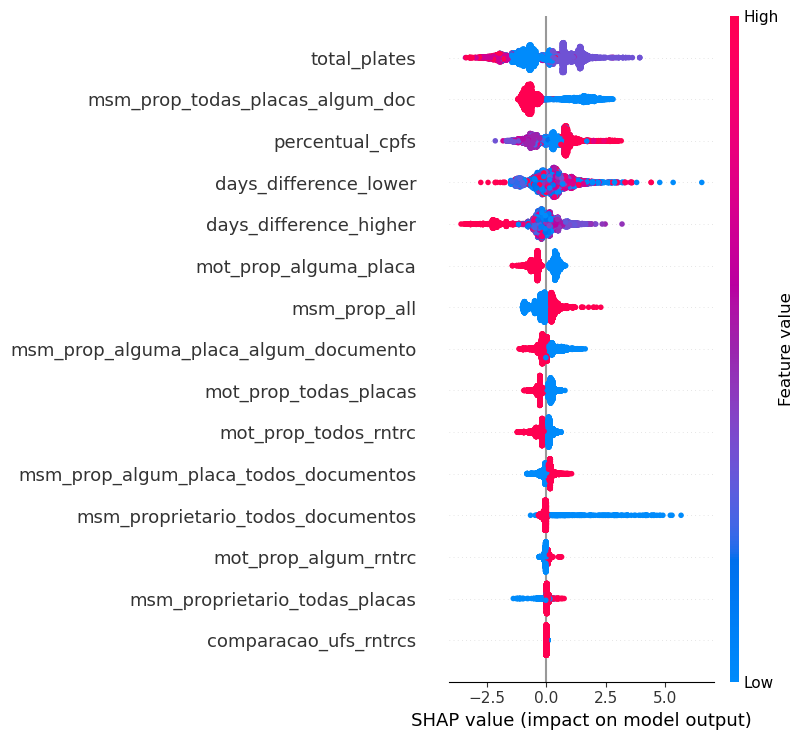

In [49]:
shap.summary_plot(shap_values_train[1], all_X_train[1], plot_type="dot")

shap.summary_plot(shap_values_test, all_X_test[0], plot_type="bar")

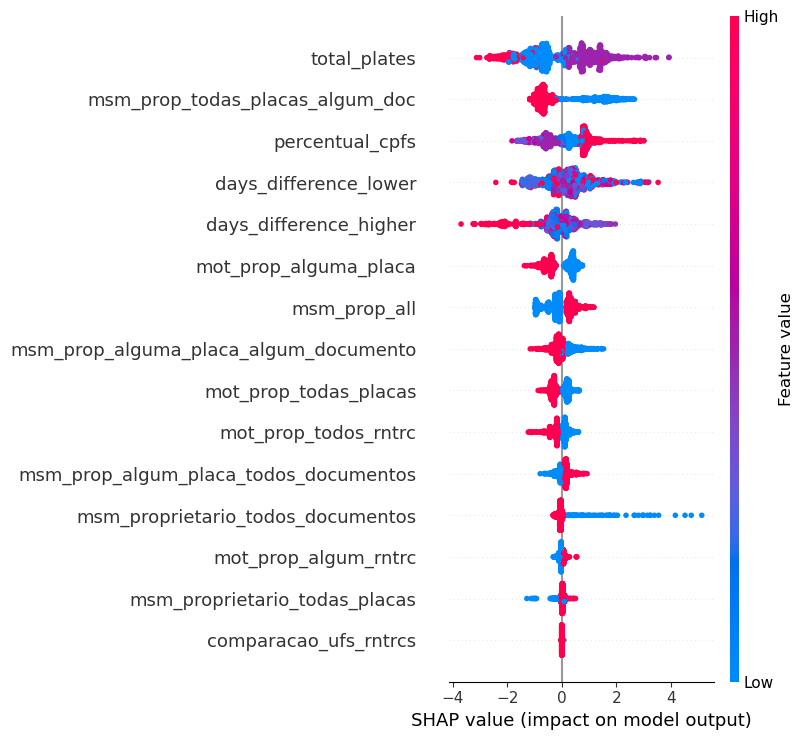

In [50]:
shap.summary_plot(shap_values_test[1], all_X_test[1], plot_type="dot")

### Model 2

In [51]:
chosen_model = trained_models[2]

explainer = shap.TreeExplainer(chosen_model)
shap_values_train = explainer.shap_values(all_X_train[2])

shap_values_test = explainer.shap_values(all_X_test[2])

shap.summary_plot(shap_values_train, all_X_train[0], plot_type="bar")

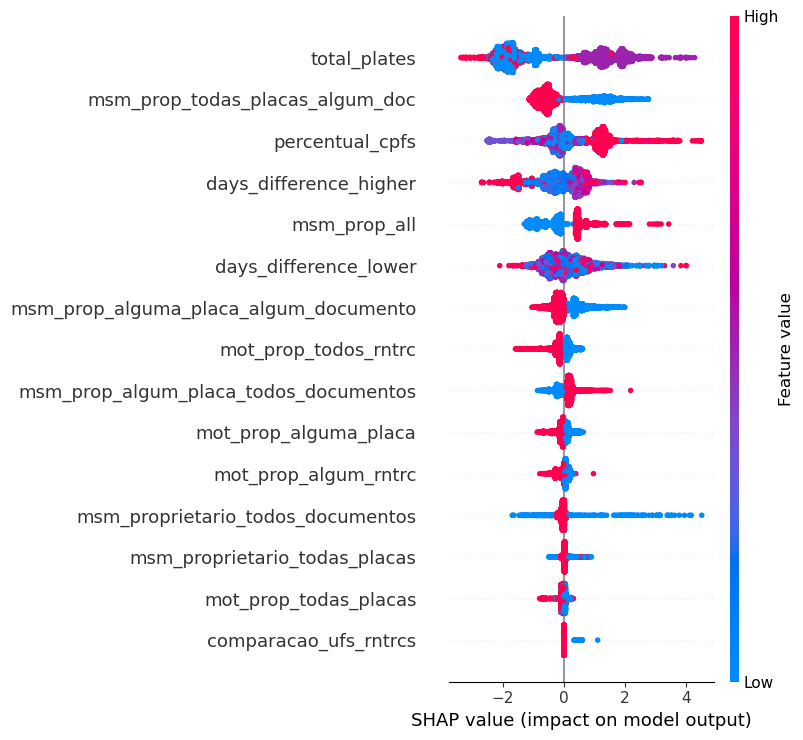

In [52]:
shap.summary_plot(shap_values_train[1], all_X_train[2], plot_type="dot")

shap.summary_plot(shap_values_test, all_X_test[0], plot_type="bar")

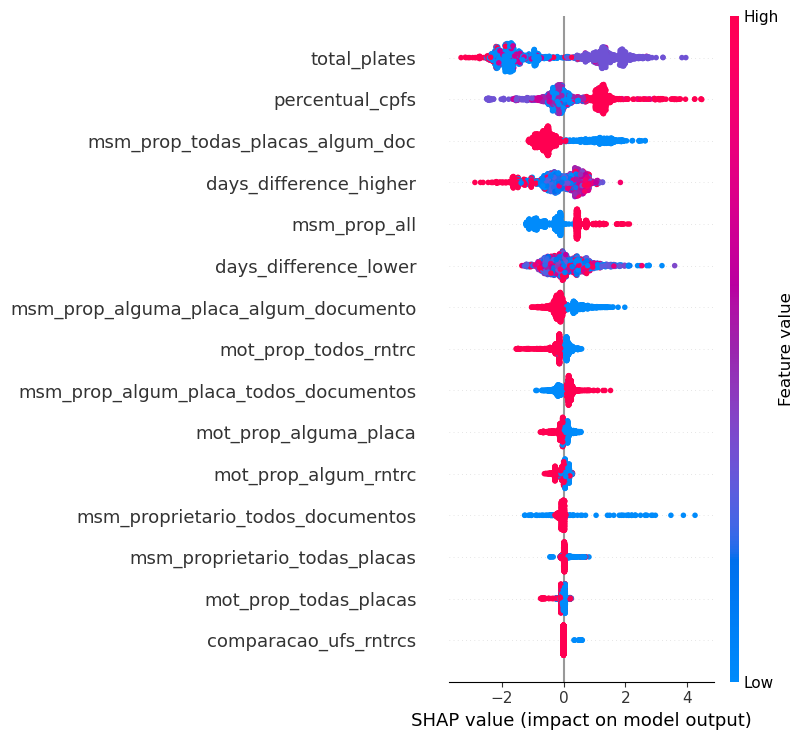

In [53]:
shap.summary_plot(shap_values_test[1], all_X_test[2], plot_type="dot")

### Model 3

In [54]:
chosen_model = trained_models[3]

explainer = shap.TreeExplainer(chosen_model)
shap_values_train = explainer.shap_values(all_X_train[3])

shap_values_test = explainer.shap_values(all_X_test[3])

shap.summary_plot(shap_values_train, all_X_train[0], plot_type="bar")

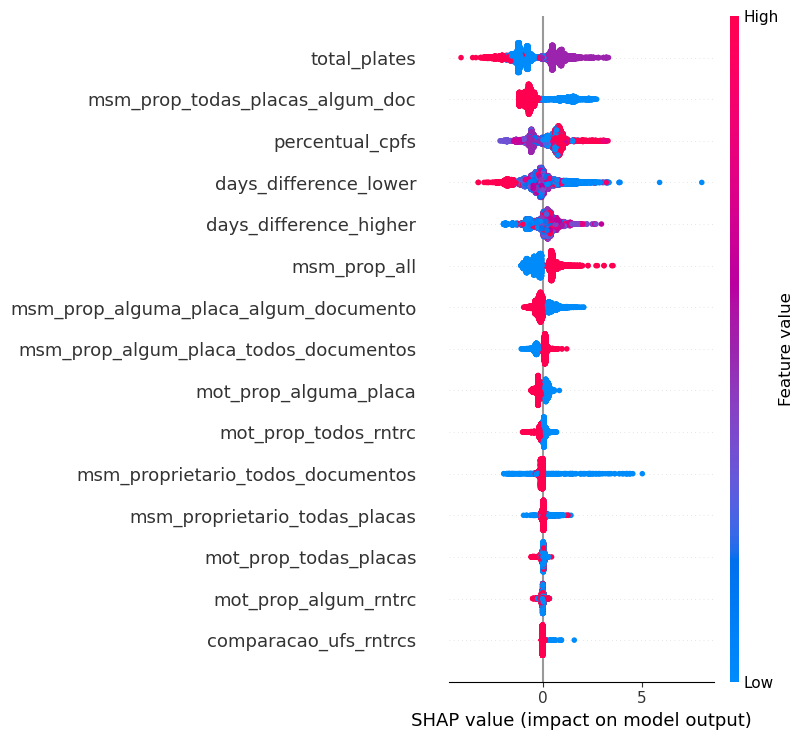

In [55]:
shap.summary_plot(shap_values_train[1], all_X_train[3], plot_type="dot")

shap.summary_plot(shap_values_test, all_X_test[0], plot_type="bar")

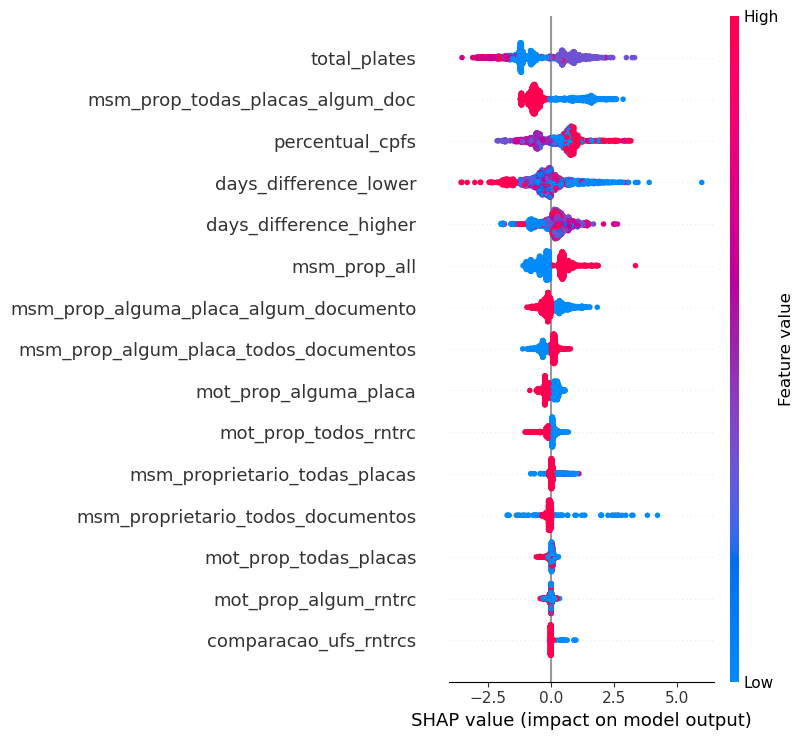

In [56]:
shap.summary_plot(shap_values_test[1], all_X_test[3], plot_type="dot")

### Model Calibration

In [57]:
from sklearn.calibration import calibration_curve

In [58]:
from sklearn.metrics import brier_score_loss, log_loss

### Calibrating the model

we can adjust the model score without really changing the model’s decisions, as long as our adjustment preserves the order of the scores

Applying a strictly monotonic function to the model always keeps the order of scores the same.

Proper scoring rules provide an alternative approach to measuring the quality of probabilistic forecasts, by using a formula to measure the distance between the model’s predictions and the true event probabilities. These rules guarantee that a better value must mean a better prediction in terms of accuracy and calibration. Such rules incentivize models to be both better calibrated and more accurate.

https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf

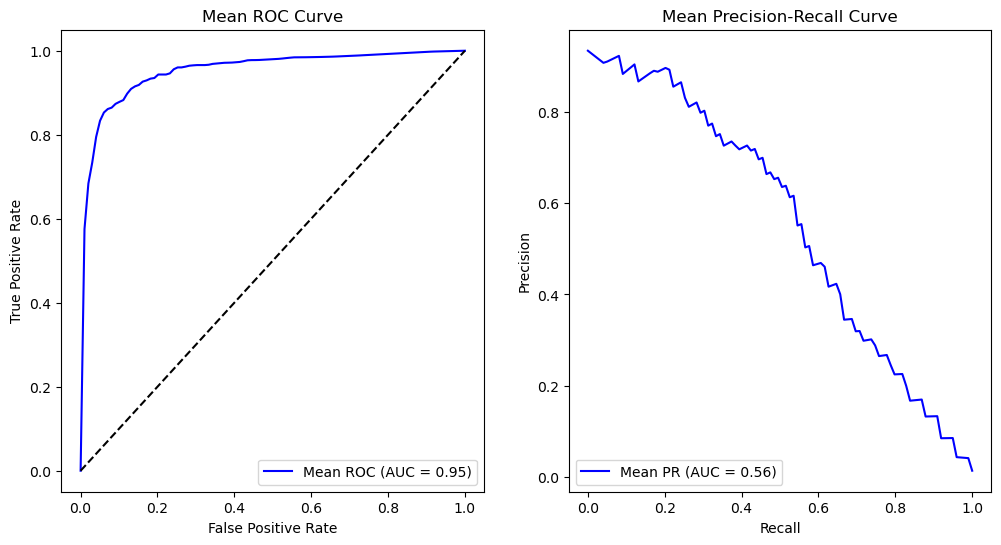

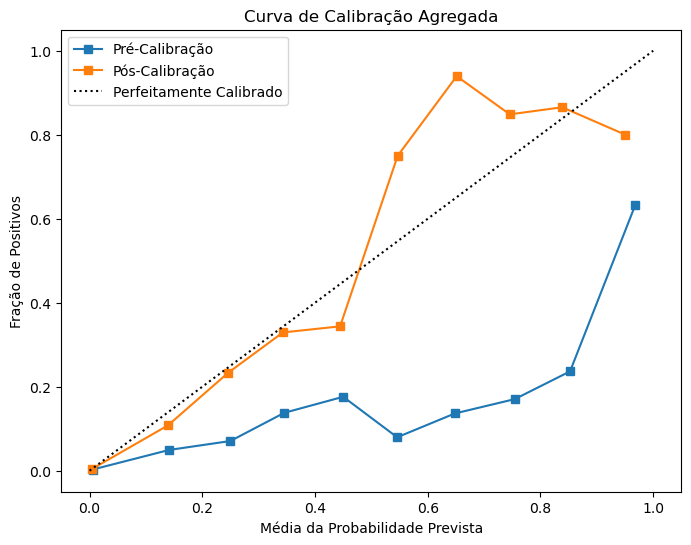

In [59]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

df_reports = []
auc_scores = []
auc_pr_scores = []
mcc_scores = []
tprs = []  
aucs_roc = [] 
precisions_list = []  
recalls_list = [] 
aucs_pr = [] 
mean_fpr = np.linspace(0, 1, 100) 
mean_recall = np.linspace(0, 1, 100) 
all_y_pred = []
all_y_test = []
trained_models = []
prob_pos_pre_calibration = []
prob_pos_post_calibration = []
true_labels = []

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    gbm = LGBMClassifier(**params)
    gbm.fit(X_train, y_train, sample_weight=sample_weights)

    y_pred_proba_pre = gbm.predict_proba(X_test)[:, 1]
    prob_pos_pre_calibration.extend(y_pred_proba_pre)
    true_labels.extend(y_test)

    calibrated_clf = CalibratedClassifierCV(base_estimator=gbm, method='isotonic', cv=5)
    calibrated_clf.fit(X_train, y_train)

    y_pred_proba_post = calibrated_clf.predict_proba(X_test)[:, 1]
    
    limiar = 0.8

    y_pred = (y_pred_proba_post >= limiar).astype(int)
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    prob_pos_post_calibration.extend(y_pred_proba_post)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    flat_report = {}
    for key, value in report.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                flat_report[f"{key}_{sub_key}"] = sub_value
        else:
            flat_report[key] = value
    
    df_reports.append(flat_report)

    auc_score = roc_auc_score(y_test, y_pred_proba_post)
    auc_scores.append(auc_score)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_post)
    auc_pr = sklearn_auc(recall, precision)
    auc_pr_scores.append(auc_pr)

    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_post)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs_roc.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_post)
    precisions_list.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
    pr_auc = auc(recall, precision)
    aucs_pr.append(pr_auc)

avg_report_df = pd.DataFrame(df_reports).mean()
avg_report_df['AUC'] = np.mean(auc_scores)
avg_report_df['AUC-PR'] = np.mean(auc_pr_scores)
avg_report_df['MCC'] = np.mean(mcc_scores)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc_roc = auc(mean_fpr, mean_tpr)

mean_precision = np.mean(precisions_list, axis=0)
mean_auc_pr = auc(mean_recall, mean_precision)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f)' % mean_auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(mean_recall, mean_precision, color='blue', label=r'Mean PR (AUC = %0.2f)' % mean_auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()

fraction_of_positives_pre, mean_predicted_value_pre = calibration_curve(true_labels, prob_pos_pre_calibration, n_bins=10)
fraction_of_positives_post, mean_predicted_value_post = calibration_curve(true_labels, prob_pos_post_calibration, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_pre, fraction_of_positives_pre, "s-", label="Pré-Calibração")
plt.plot(mean_predicted_value_post, fraction_of_positives_post, "s-", label="Pós-Calibração")
plt.plot([0, 1], [0, 1], "k:", label="Perfeitamente Calibrado")
plt.xlabel('Média da Probabilidade Prevista')
plt.ylabel('Fração de Positivos')
plt.title('Curva de Calibração Agregada')
plt.legend()
plt.show()

In [60]:
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

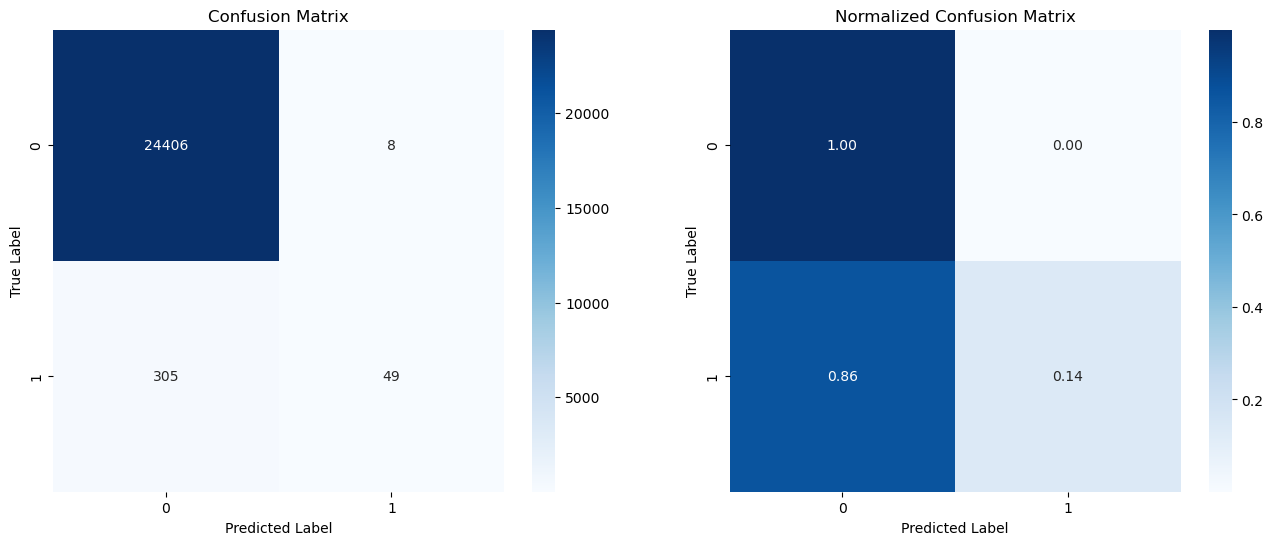

In [61]:
plot_confusion_matrixs(all_y_test, all_y_pred)

### Adjusting threshold

In [62]:
X.columns

Index(['mot_prop_alguma_placa', 'mot_prop_todas_placas',
       'mot_prop_algum_rntrc', 'mot_prop_todos_rntrc',
       'msm_proprietario_todas_placas', 'msm_proprietario_todos_documentos',
       'msm_prop_alguma_placa_algum_documento',
       'msm_prop_algum_placa_todos_documentos',
       'msm_prop_todas_placas_algum_doc', 'msm_prop_all',
       'comparacao_ufs_rntrcs', 'days_difference_lower',
       'days_difference_higher', 'total_plates', 'percentual_cpfs'],
      dtype='object')

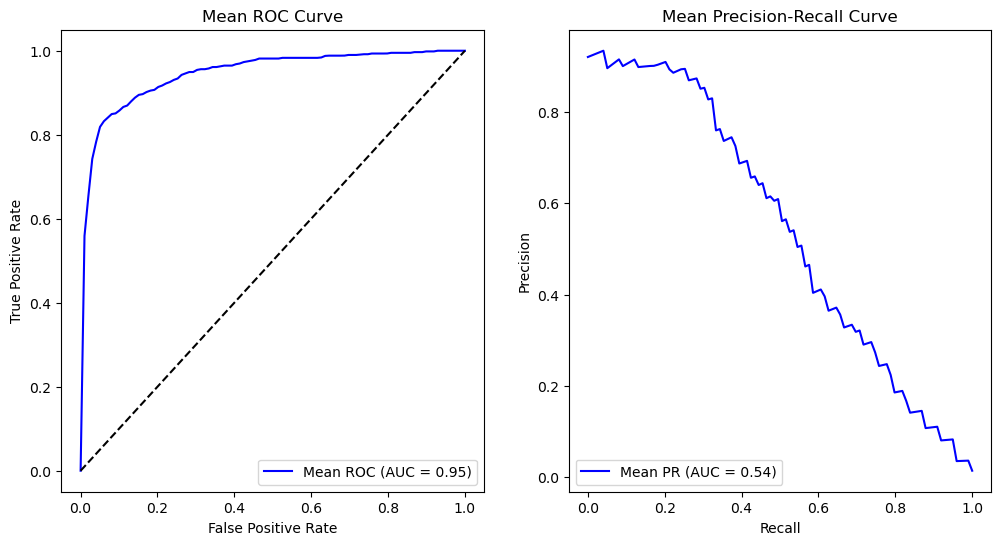

In [63]:
df_reports = []
auc_scores = []
auc_pr_scores = []
mcc_scores = []
tprs = []  
aucs_roc = []  
precisions_list = [] 
recalls_list = [] 
aucs_pr = [] 
mean_fpr = np.linspace(0, 1, 100)  
mean_recall = np.linspace(0, 1, 100)  
all_y_pred = []
all_y_pred_proba = []
trained_models = []
all_X_train = []
all_X_test = []
all_y_train = []
all_y_test = []
all_y_test_list = []
all_y_pred_list = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    all_X_train.append(X_train)
    all_X_test.append(X_test)
    all_y_train.extend(y_train)
    all_y_test.extend(y_test)
    all_y_test_list.append(y_test)

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    gbm = LGBMClassifier(**params)
    gbm.fit(X_train, y_train, sample_weight=sample_weights)
    
    trained_models.append(gbm)

    y_pred_proba = gbm.predict_proba(X_test)[:, 1]
    
    limiar = 0.75

    y_pred = (y_pred_proba >= limiar).astype(int)
    
    all_y_pred.extend(y_pred)
    all_y_pred_list.append(y_pred)
    all_y_pred_proba.extend(y_pred_proba)

    report = classification_report(y_test, y_pred, output_dict=True)
    
    flat_report = {}
    for key, value in report.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                flat_report[f"{key}_{sub_key}"] = sub_value
        else:
            flat_report[key] = value
    
    df_reports.append(flat_report)

    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc_score)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_pr = sklearn_auc(recall, precision)
    auc_pr_scores.append(auc_pr)

    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs_roc.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    precisions_list.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
    pr_auc = auc(recall, precision)
    aucs_pr.append(pr_auc)

avg_report_df = pd.DataFrame(df_reports).mean()
avg_report_df['AUC'] = np.mean(auc_scores)
avg_report_df['AUC-PR'] = np.mean(auc_pr_scores)
avg_report_df['MCC'] = np.mean(mcc_scores)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc_roc = auc(mean_fpr, mean_tpr)

mean_precision = np.mean(precisions_list, axis=0)
mean_auc_pr = auc(mean_recall, mean_precision)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f)' % mean_auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(mean_recall, mean_precision, color='blue', label=r'Mean PR (AUC = %0.2f)' % mean_auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()

In [64]:
report_df = pd.DataFrame(avg_report_df)
report_df = report_df.reset_index()
report_df[['Metric', 'Measure']] = report_df['index'].str.rsplit('_', n=1, expand=True)
report_df.drop(columns='index', inplace=True)
report_df = report_df.pivot(index='Metric', columns='Measure', values=0)
report_df.columns = ['drop', 'f1-score', 'precision', 'recall', 'support']
report_df.drop(columns='drop', inplace=True)

for metric in ['accuracy', 'AUC', 'AUC-PR', 'MCC']:
    report_df.loc[metric] = [avg_report_df.get(metric)] * 4

x = PrettyTable()

x.field_names = [''] + list(report_df.columns)

for index, row in report_df.iterrows():
    x.add_row([index] + list(round(row, 2)))

print(x)

+--------------+----------+-----------+--------+---------+
|              | f1-score | precision | recall | support |
+--------------+----------+-----------+--------+---------+
|      0       |   0.99   |    0.99   |  0.99  |  1627.6 |
|      1       |   0.5    |    0.48   |  0.53  |   23.6  |
|     AUC      |   0.95   |    0.95   |  0.95  |   0.95  |
|    AUC-PR    |   0.54   |    0.54   |  0.54  |   0.54  |
|     MCC      |   0.5    |    0.5    |  0.5   |   0.5   |
|   accuracy   |   0.98   |    0.98   |  0.98  |   0.98  |
|  macro avg   |   0.75   |    0.74   |  0.76  |  1651.2 |
| weighted avg |   0.99   |    0.99   |  0.98  |  1651.2 |
+--------------+----------+-----------+--------+---------+


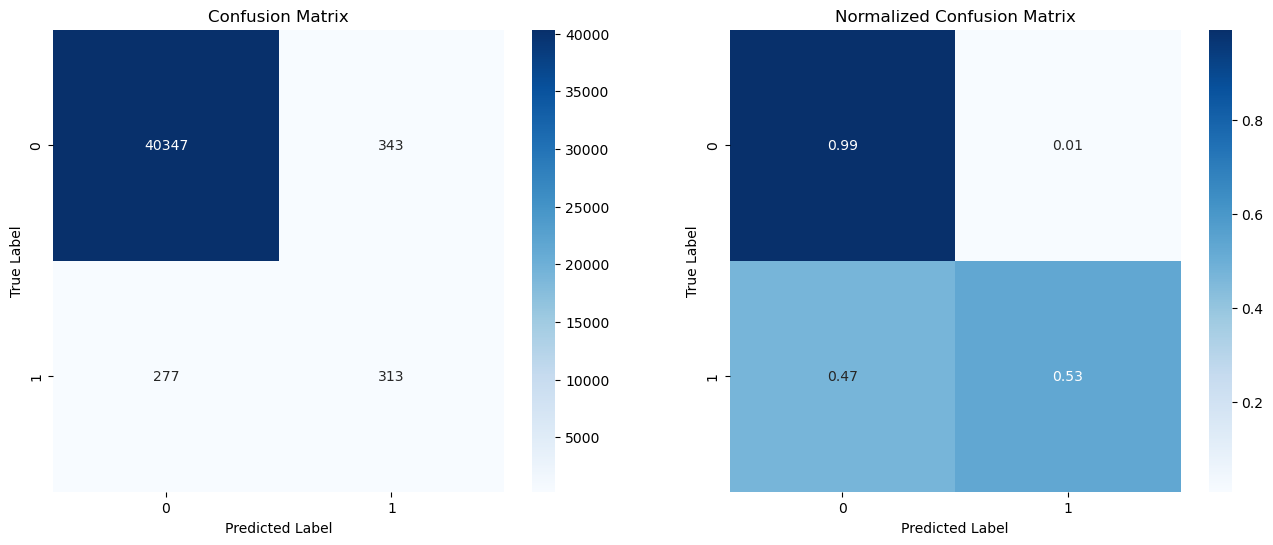

In [65]:
plot_confusion_matrixs(all_y_test, all_y_pred)

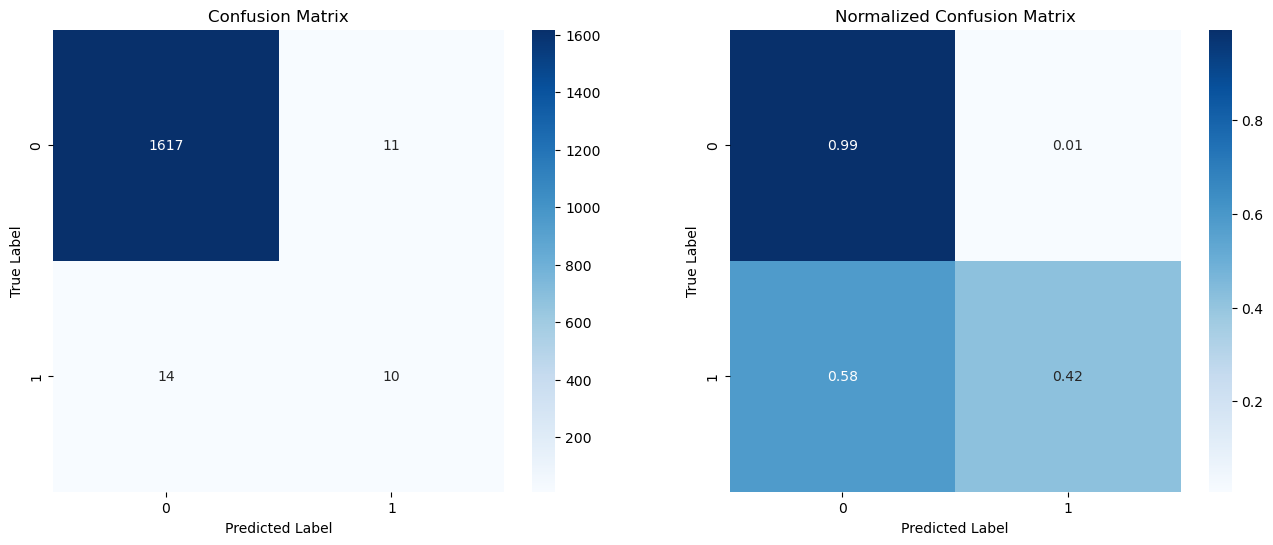

In [66]:
plot_confusion_matrixs(all_y_test_list[0], all_y_pred_list[0])

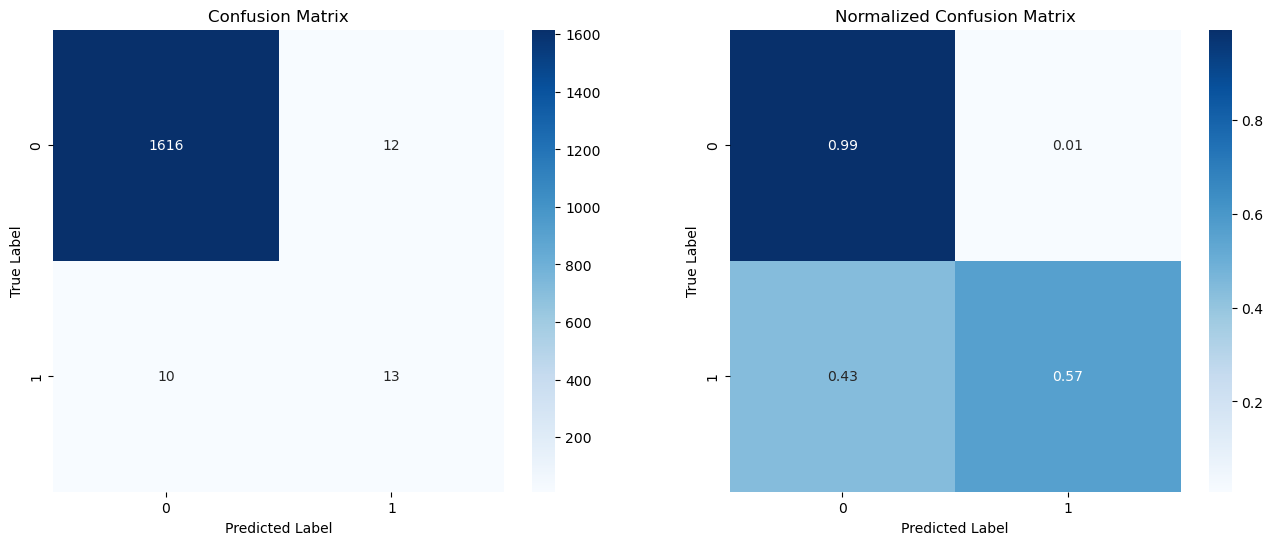

In [67]:
plot_confusion_matrixs(all_y_test_list[1], all_y_pred_list[1])

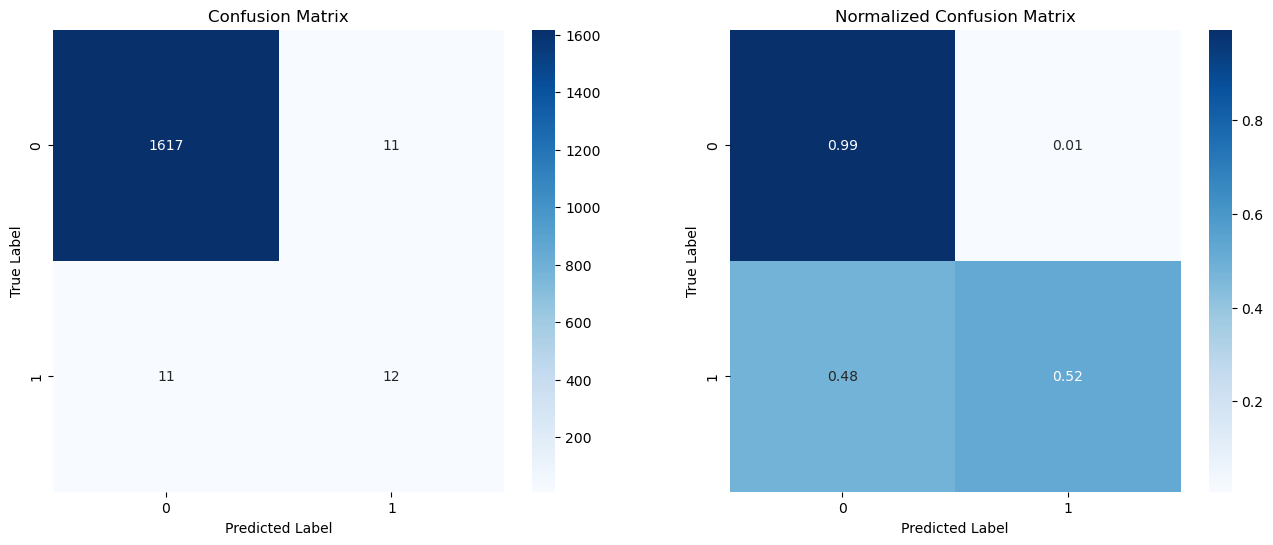

In [68]:
plot_confusion_matrixs(all_y_test_list[2], all_y_pred_list[2])

### Training final model

In [69]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

In [70]:
gbm = LGBMClassifier(**params)
gbm.fit(X, y, sample_weight=sample_weights)

LGBMClassifier(bagging_fraction=0.9, learning_rate=0.05, metric='auc',
               n_estimators=200, num_leaves=20, objective='binary', reg_alpha=0,
               reg_lambda=0, verbose=-1)

In [71]:
X.columns

Index(['mot_prop_alguma_placa', 'mot_prop_todas_placas',
       'mot_prop_algum_rntrc', 'mot_prop_todos_rntrc',
       'msm_proprietario_todas_placas', 'msm_proprietario_todos_documentos',
       'msm_prop_alguma_placa_algum_documento',
       'msm_prop_algum_placa_todos_documentos',
       'msm_prop_todas_placas_algum_doc', 'msm_prop_all',
       'comparacao_ufs_rntrcs', 'days_difference_lower',
       'days_difference_higher', 'total_plates', 'percentual_cpfs'],
      dtype='object')

In [86]:
import pickle
with open("model.pkl", 'wb') as arquivo_pkl:
    pickle.dump(gbm, arquivo_pkl)